# Some Plotting Options: Summary Statistics, Pairwise Comparison Graphs, and MDS Plots.

In this tutorial we will explore various plotting options included in `votekit`. To do so, we will not use real election data, but rather some generated preference profiles. `votekit` allows us to choose many different models of ballot generator.

For simplicity, let's start with the Impartial Culture model, which assumes that when there are $m$ candidates, a voter casts a ballot by choosing uniformly at random from the $m!$ total linear orderings of the candidates.

In [1]:
import votekit.ballot_generator as bg
from votekit.plots import plot_summary_stats, plot_MDS, compute_MDS
from votekit.graphs import PairwiseComparisonGraph
from votekit.metrics import earth_mover_dist, lp_dist
from votekit.pref_interval import PreferenceInterval
from functools import partial
import matplotlib.pyplot as plt

In [2]:
# the list of candidates
candidates = ["A", "B", "C"]

# initializing the ballot generator
ic = bg.ImpartialCulture(candidates=candidates)

# generate 5 ballots under the IC model
number_of_ballots = 5
profile = ic.generate_profile(number_of_ballots)

# since this is a small preference profile, we can print the entire thing
print(profile)

  Ballots Weight
(A, C, B)      2
(B, C, A)      1
(C, B, A)      1
(A, B, C)      1


`votekit` comes with some basic summary statistics to help you analyze a profile. We can plot the number of first place votes each candidate received, the number of mentions they receive (i.e. the total number of times they appeared on a ballot), and a Borda count, which assigns $n-1$ points to the first place winner of a ballot, $n-2$ to the second place, ..., and 0 to the last place winner of a ballot.

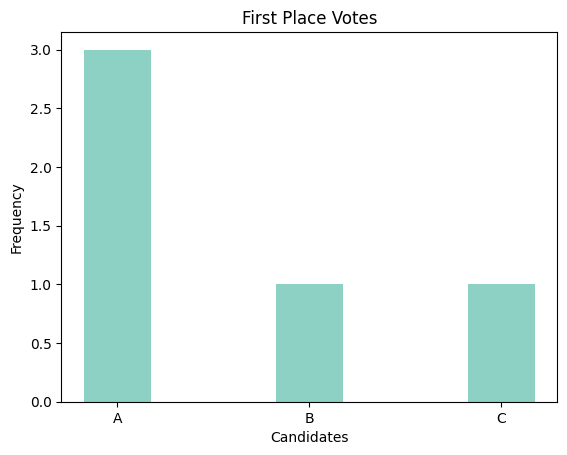

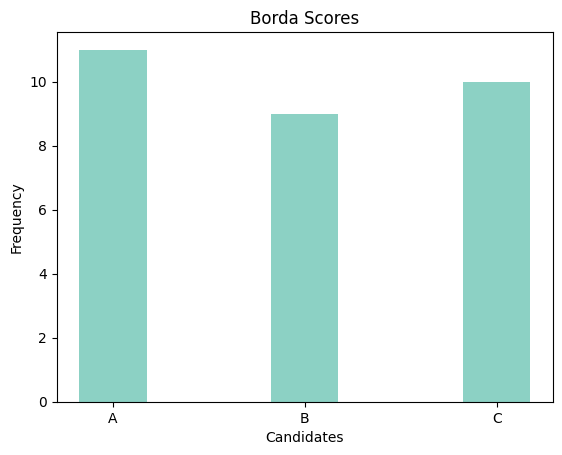

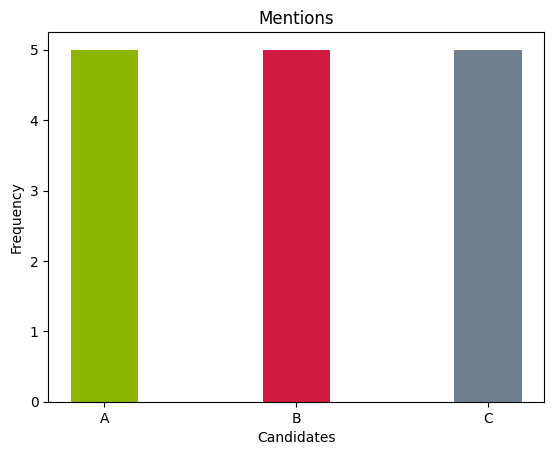

In [3]:
fig = plot_summary_stats(profile, "first place votes", multi_color = False, title = "First Place Votes")
fig = plot_summary_stats(profile, "borda", multi_color = False, title = "Borda Scores")
fig = plot_summary_stats(profile, "mentions", multi_color = True, title = "Mentions")

Check for understanding: In the IC model we are using, why is the number of mentions uniform?

# Graphs!

There are two kinds of graphs (networks) that `votekit` generates, a pairwise comparison graph, and a ballot graph. The former has vertices=candidates, and an edge going from A to B if A is preferred to B more often in the given preference profile. The edge is given weight equal to the number of times A is preferred to B minus the number of times B is preferred to A. We'll discuss ballot graphs in a later tutorial.

# `PairwiseComparisonGraph`

`PairwiseComparisonGraph` takes in a `PreferenceProfile`. There is an optional `ballot_length` parameter that determines the length of the ballot and then the `PairwiseComparisonGraph` graph will randomly fill in any ballots that are too short. Since we are using IC ballots which have a full linear ranking, we don't need to worry about that.

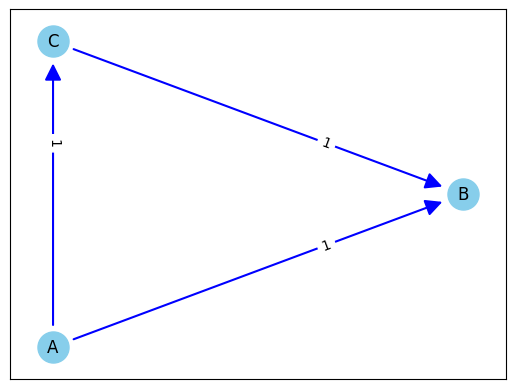

In [4]:
pwc_graph = PairwiseComparisonGraph(profile)
pwc_graph.draw()

Check for understanding: are the edge weights what you expect given your `PreferenceProfile`?

`PairwiseComparisonGraph` has methods for computing dominating tiers and the existence of a condorcet winner. A dominating tier is a group of candidates that beats every candidate not in the set in a head-to-head comparison. A condorcet winner is a candidate who wins every head-to-head contest with every other candidate.

In [5]:
print(pwc_graph.dominating_tiers())
print()
print(pwc_graph.has_condorcet_winner())

[{'A'}, {'C'}, {'B'}]

True


# MDS Plots

One of the cool features of `votekit` is that we can create MDS plots, using different notions of distance between preference profiles. An MDS plot, in short, is a 2D representation of high dimensional data that attempts to minimize the distortion of the data. `votekit` comes with two distance metrics, the earthmover distance and the $L_p$ distance.

Let's explore how an MDS plot can show us the difference between different types of ballot generating models. We will explain what these generating models are doing in a different tutorial.

In [6]:
number_of_ballots = 1000


candidates = ["W1", "W2", "C1", "C2"]
slate_to_candidate = {"W": ["W1", "W2"], "C": ["C1", "C2"]}
cohesion_parameters = {"W":{"W": .7, "C":.3},
                       "C":{ "C": .6, "W":.4}}
pref_intervals_by_bloc = {
    "W": {"W": PreferenceInterval({"W1": 0.4, "W2": 0.3}), 
          "C": PreferenceInterval({"C1": 0.2, "C2": 0.1})},
    "C": {"W": PreferenceInterval({"W1": 0.2, "W2": 0.2}), 
          "C": PreferenceInterval({"C1": 0.3, "C2": 0.3})}
}
bloc_voter_prop = {"W": 0.7, "C": 0.3}

ic = bg.ImpartialCulture(candidates=candidates)

pl = bg.name_PlackettLuce(pref_intervals_by_bloc=pref_intervals_by_bloc,
                     bloc_voter_prop=bloc_voter_prop, candidates=candidates, 
                     cohesion_parameters=cohesion_parameters)

bt = bg.name_BradleyTerry(pref_intervals_by_bloc=pref_intervals_by_bloc,
                     bloc_voter_prop=bloc_voter_prop, candidates=candidates,
                     cohesion_parameters=cohesion_parameters)

ac = bg.AlternatingCrossover(pref_intervals_by_bloc=pref_intervals_by_bloc,
                             bloc_voter_prop=bloc_voter_prop, candidates=candidates,
                             slate_to_candidates=slate_to_candidate, cohesion_parameters=cohesion_parameters)

`compute_MDS` takes in a `data` parameter, which is a dictionary whose keys are labels and whose values are a particular list of `PreferenceProfiles`, and a `distance` parameter that sets the metric between preference profiles. Since computing these coordinates is the most time intensive part of the process, it has been decoupled from `plot_mds` which simply takes the output of `compute_MDS` and plots the data.

`comput_MDS` also comes with an optional `random_seed` parameter that allows for MDS replication.

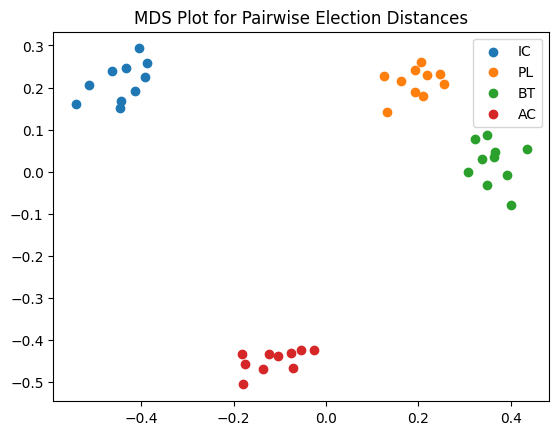

In [7]:
# this allows us to generate 10 preference profiles under each ballot generator
mds_coords = compute_MDS(data = {'IC': [ic.generate_profile(number_of_ballots) for i in range(10)], 
                        'PL': [pl.generate_profile(number_of_ballots) for i in range(10)], 
                        'BT': [bt.generate_profile(number_of_ballots) for i in range(10)],
                       'AC': [ac.generate_profile(number_of_ballots) for i in range(10)]
                       }, distance = earth_mover_dist)

plot = plot_MDS(mds_coords)
plt.legend()
plt.show()

Let's try a different metric.

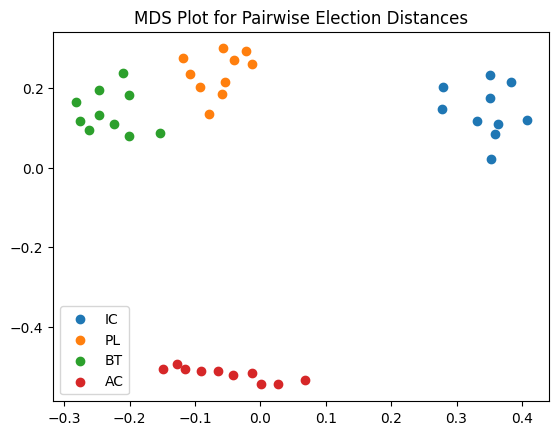

In [8]:
# this allows us to generate 10 preference profiles under each ballot generator
mds_coords = compute_MDS(data = {'IC': [ic.generate_profile(number_of_ballots) for i in range(10)], 
                        'PL': [pl.generate_profile(number_of_ballots) for i in range(10)], 
                        'BT': [bt.generate_profile(number_of_ballots) for i in range(10)],
                       'AC': [ac.generate_profile(number_of_ballots) for i in range(10)]
                       }, distance = lp_dist)

plot = plot_MDS(mds_coords)
plt.legend()
plt.show()

By default, the $L_p$ distance function uses $p=1$. If you want to change that, we need the `partial` function from the `functools` module.

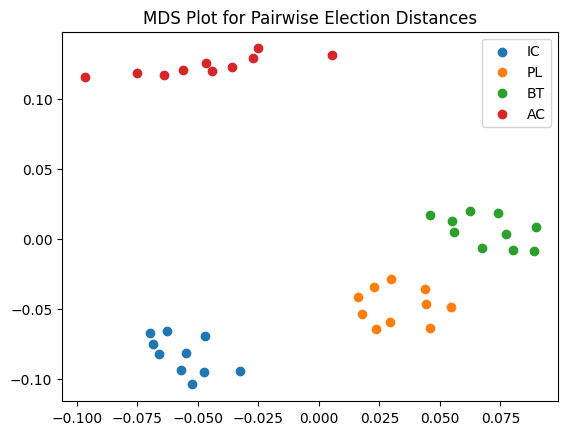

In [9]:
# this allows us to generate 10 preference profiles under each ballot generator
mds_coords = compute_MDS(data = {'IC': [ic.generate_profile(number_of_ballots) for i in range(10)], 
                        'PL': [pl.generate_profile(number_of_ballots) for i in range(10)], 
                        'BT': [bt.generate_profile(number_of_ballots) for i in range(10)],
                       'AC': [ac.generate_profile(number_of_ballots) for i in range(10)]
                       }, distance = partial(lp_dist, p_value=2))

plot = plot_MDS(mds_coords)
plt.legend()
plt.show()

Finally, to use the $L_\infty$ distance, use the keyword `inf`.

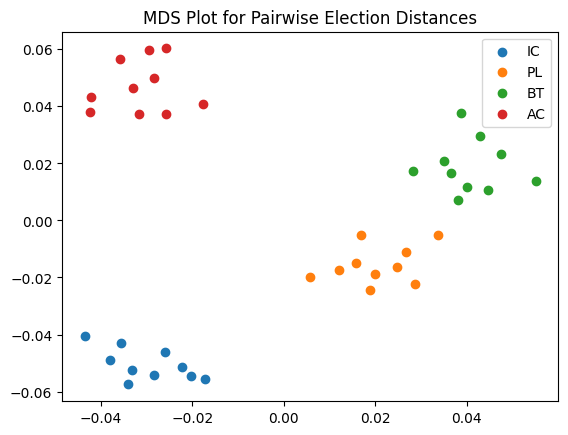

In [10]:
# this allows us to generate 10 preference profiles under each ballot generator
mds_coords = compute_MDS(data = {'IC': [ic.generate_profile(number_of_ballots) for i in range(10)], 
                        'PL': [pl.generate_profile(number_of_ballots) for i in range(10)], 
                        'BT': [bt.generate_profile(number_of_ballots) for i in range(10)],
                       'AC': [ac.generate_profile(number_of_ballots) for i in range(10)]
                       }, distance = partial(lp_dist, p_value="inf"))

plot = plot_MDS(mds_coords)
plt.legend()
plt.show()